# Context Dependent Generalization
____
This demonstration is the same problem set as in the notebook `Demonstrations for paper.ipynb`. Here, the agent's learn the full transition functions as we are not assuming the agents have access to the relationship between locations in the grid world. In order to aid exploration, the agents here use Thompson sampling on the posterior distribution over cluster assignements, in contrast to the agents in `Demonstrations for paper.ipynb`, which used a MAP approximation. 

In [1]:
%matplotlib inline
from model.gridworld import make_task
from model import simulate_task_transitions, list_entropy, mutual_information, plot_results

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('paper', font_scale=1.5)

# Task 1
The first set of simulations are on a set of 6x6 gridworlds. There are 4 contexts with
a total of 4 goal locations (one at each corner) and 2 skill sets (relationship between actions and movements). No two contexts share both a goal and a skill set, but generalization is still possible between them.

In [2]:
# define all of the task parameters
grid_world_size = (6, 6)

# define mapping between primitive action (a in [0, 1]) and cardinal movements
# (left, right, up down)
mapping_definitions = {
    0: {0: u'left', 1: u'up', 2: u'down', 3: u'right'},
    1: {4: u'up', 5: u'left', 6: u'right', 7: u'down'},
}

# define goal locations in (x, y) coordinate space
goal_locations = {
    0:(0, 0),
    1:(0, 5),
    2:(5, 0),
    3:(5, 5),
}


# assign goals and mappings to contexts
context_goals = [0, 3, 0, 3]
context_maps =  [0, 0, 1, 1]

# randomly start the agent somewhere in the middle of the map
start_locations = [(x, y) for x in range(1, 5) for y in range(1, 5)]

# the number of times each context is shown
context_balance = [4] * len(context_goals)

# the hazard rate determines a degree of auto correlation in the context orders. This is
# useful in human studies. The hazard rates is the defined by the probability of a 
# context change after i repeats is f(i)
hazard_rates = [0.5, 0.67, 0.67, 0.75, 1.0, 1.0]


task_kwargs = dict(context_balance=context_balance, 
                   context_goals=[goal_locations[g] for g in context_goals], 
                   context_maps=[mapping_definitions[m] for m in context_maps],
                   hazard_rates=hazard_rates, start_locations=start_locations,
                   grid_world_size=grid_world_size,
                   )

In [3]:
print "Entropy H(G):   %.2f" % list_entropy(context_goals)
print "Entropy H(M):   %.2f" % list_entropy(context_maps)
print "Mutual Information I(G,M): %.2f" % mutual_information(context_goals, context_maps)

Entropy H(G):   1.00
Entropy H(M):   1.00
Mutual Information I(G,M): 0.00


Now, we simulate each model a couple hundred times (this can take a while) and plot the cumulative number of steps taken across 
trials. In the task, the agent must reach the goal (an absorbing state with positive reward)
to advance to the next trial. Lower cumulative steps taken indicated faster learning.

In [4]:
n_sim = 150
seed = 234234
sim1 = simulate_task_transitions(n_sim, task_kwargs, alpha=1.0, seed=seed)

100%|██████████| 150/150 [55:01<00:00, 31.70s/it]


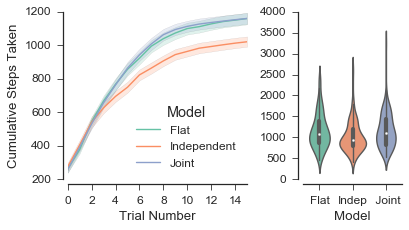

In [5]:
plot_results(sim1, sharey=False)
fig = plt.gcf()
fig.axes[1].set_xticklabels(['Flat', 'Indep',' Joint'])
fig.axes[1].set_ylabel('')
# fig.savefig('Sim1.png', bbox_inches='tight', dpi=300)

In [6]:
df0 = sim1[sim1['In goal']].groupby(['Model', 'Simulation Number', 'Trial Number']).mean()
df0 = df0.groupby(level=[0, 1]).cumsum().reset_index()
df0 = df0.rename(index=str, columns={'n actions taken': "Cumulative Steps Taken"})
df0 = df0[df0['Trial Number'] == df0['Trial Number'].max()]
# sim1.groupby(['Model', 'Simulation Number']).mean()
print df0.groupby('Model').mean()['Cumulative Steps Taken']
print df0.groupby('Model')['Cumulative Steps Taken'].std()

Model
Flat           1159.720000
Independent    1021.006667
Joint          1160.253333
Name: Cumulative Steps Taken, dtype: float64
Model
Flat           424.850848
Independent    377.908666
Joint          408.259560
Name: Cumulative Steps Taken, dtype: float64


In [7]:
from scipy.stats import ttest_ind, f_oneway
import numpy as np
x0 = df0.loc[df0.Model == 'Flat', 'Cumulative Steps Taken']
x1 = df0.loc[df0.Model == 'Independent', 'Cumulative Steps Taken']
x2 = df0.loc[df0.Model == 'Joint', 'Cumulative Steps Taken']

xs = [x0, x1, x2]
ps = np.zeros((3,3))
for ii in range(3):
    for jj in range(3):
        t, p = ttest_ind(xs[ii], xs[jj])
        ps[ii, jj] = p

print f_oneway(x0, x1, x2)
print ps

F_onewayResult(statistic=5.9130871082266339, pvalue=0.0029198607210644072)
[[ 1.          0.00304357  0.99116234]
 [ 0.00304357  1.          0.00237185]
 [ 0.99116234  0.00237185  1.        ]]


## Task 2: 4 Mappings, 4 Goals

In the example above, jointly clustering goals and mappings ends up being faster than no clustering at all because there is still an advantagege of clustering the mappings. We can see this by introducing two new mappings that partially overlap with the previous mappings to reduce the benefit of generalizing the mapping.

In [8]:
seed = 65756
n_sim = 150

In [9]:
# define all of the task parameters here

mapping_definitions = {
    0: {0: u'left', 1: u'up', 2: u'down', 3: u'right'},
    1: {4: u'up', 5: u'left', 6: u'right', 7: u'down'},
    2: {0: u'left', 1: u'up', 6: u'right', 7: u'down'},
    3: {4: u'up', 5: u'left', 2: u'down', 3: u'right'},
}


# assign goals and mappings to contexts
context_goals = [0, 0, 1, 1, 2, 2, 3, 3]
context_maps =  [0, 0, 1, 1, 2, 2, 3, 3]

# the number of times each context is shown
context_balance = [4] * len(context_goals)

# we include a prior in the reward funconetion over the goal locations
list_goal_priors = goal_locations.values()

task_kwargs = dict(context_balance=context_balance, 
                   context_goals=[goal_locations[g] for g in context_goals], 
                   context_maps=[mapping_definitions[m] for m in context_maps],
                   hazard_rates=hazard_rates, start_locations=start_locations,
                   grid_world_size=grid_world_size
                  )

# simulate the agents
sim2 = simulate_task_transitions(n_sim, task_kwargs, alpha=1.0, 
                     seed=seed,
                     evaluate=True)

100%|██████████| 150/150 [6:28:48<00:00, 113.50s/it]


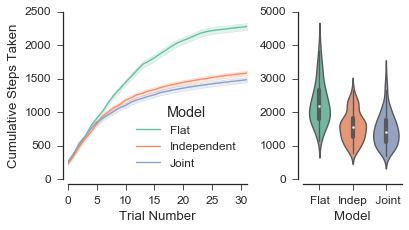

In [10]:
plot_results(sim2, sharey=False)
fig = plt.gcf()
fig.axes[1].set_xticklabels(['Flat', 'Indep',' Joint'])
fig.axes[1].set_ylabel('')
# plt.savefig('Sim2.png', dpi=300)

In [11]:
df0 = sim2[sim2['In goal']].groupby(['Model', 'Simulation Number', 'Trial Number']).mean()
df0 = df0.groupby(level=[0, 1]).cumsum().reset_index()
df0 = df0.rename(index=str, columns={'n actions taken': "Cumulative Steps Taken"})
df0 = df0[df0['Trial Number'] == df0['Trial Number'].max()]
print df0.groupby('Model').mean()['Cumulative Steps Taken']
print df0.groupby('Model')['Cumulative Steps Taken'].std()

Model
Flat           2280.006667
Independent    1583.633333
Joint          1485.813333
Name: Cumulative Steps Taken, dtype: float64
Model
Flat           653.783562
Independent    449.104708
Joint          496.413275
Name: Cumulative Steps Taken, dtype: float64


In [12]:
from scipy.stats import ttest_ind, f_oneway
x0 = df0.loc[df0.Model == 'Flat', 'Cumulative Steps Taken']
x1 = df0.loc[df0.Model == 'Independent', 'Cumulative Steps Taken']
x2 = df0.loc[df0.Model == 'Joint', 'Cumulative Steps Taken']

xs = [x0, x1, x2]
ps = np.zeros((3,3))
for ii in range(3):
    for jj in range(3):
        t, p = ttest_ind(xs[ii], xs[jj])
        ps[ii, jj] = p

print f_oneway(x0, x1, x2)
print ps

F_onewayResult(statistic=96.388754610503639, pvalue=1.5712919770275572e-35)
[[  1.00000000e+00   5.27282217e-23   8.46932326e-27]
 [  5.27282217e-23   1.00000000e+00   7.45205453e-02]
 [  8.46932326e-27   7.45205453e-02   1.00000000e+00]]
